In [2]:
import numpy as np
import porepy as pp
import FTHM_Solver
import scipy.stats as stats
from pprint import pprint


import time
import pandas as pd
import copy
from joblib import Parallel, delayed, parallel_backend
import itertools
import gmsh

import math
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Flow set up 

Set up the flow problem, from flow_setup.py  
Here the number of fractures is small, 11, for simplicity.

In [3]:
from porepy.examples.flow_benchmark_2d_case_4 import (
    FlowBenchmark2dCase4Model,
    solid_constants as solid_constants_2d,
)


class StochasticGeometry:
    def set_fractures(self):
        np.random.seed(self.params.get("seed", 42))

        num_fractures = self.params.get("num_fractures", 10)

        # Generate random fracture orientations. For now, we assume uniform distribution
        # of orientations in the range [0, pi]. We may change this later.
        orientation_distr = stats.uniform(loc=0, scale=np.pi)
        orientation = orientation_distr.rvs(size=num_fractures)

        # Represent fracture lengths as a log-normal distribution. The parameters set
        # here are quite random.
        length_distr = stats.lognorm(s=1, scale=0.5)
        lengths = length_distr.rvs(size=num_fractures)

        # Generate random fracture centers. For now, we assume uniform distribution
        # of positions in the range [0, 1] in both x and y directions.
        position_distr = stats.uniform(loc=0, scale=1)
        positions_x = position_distr.rvs(size=num_fractures)
        positions_y = position_distr.rvs(size=num_fractures)

        # Create the endpoints of the fractures based on the lengths and orientations.
        endpoints = []
        for i in range(num_fractures):
            cx = positions_x[i]
            cy = positions_y[i]
            length = lengths[i]
            theta = orientation[i]

            x0 = cx - 0.5 * length * np.cos(theta)
            y0 = cy - 0.5 * length * np.sin(theta)

            p0 = np.array([x0, y0]).reshape((2, 1))

            x1 = cx + 0.5 * length * np.cos(theta)
            y1 = cy + 0.5 * length * np.sin(theta)
            p1 = np.array([x1, y1]).reshape((2, 1))

            endpoints.append(np.hstack([p0, p1]))

        # Create the fractures as line segments.
        fractures = []
        for point_pairs in endpoints:
            fractures.append(pp.LineFracture(point_pairs))

        # Set the fractures in the model.
        self._fractures = fractures

    def grid_type(self):
        return "simplex"


class Source:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        domain = self.domain
        box = domain.bounding_box_from_polytope()

        x_mean = (box["xmax"] + box["xmin"]) / 2
        y_mean = (box["ymax"] + box["ymin"]) / 2

        src_ambient = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd)
        )
        src_fracture = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd - 1)
        )
        src_intersection = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim < self.nd - 1)
        )

        if len(self._fractures) == 0:
            # Domain without fractures. Put the source in the center of the domain.
            sd = subdomains[0]
            closest_cell = sd.closest_cell(
                np.array([x_mean, y_mean, 0]).reshape((3, 1))
            )
            src_ambient[closest_cell] = 1.0
        else:
            x, y, z = np.concatenate(
                [sd.cell_centers for sd in subdomains if sd.dim == self.nd - 1], axis=1
            )
            source_loc = np.argmin((x - x_mean) ** 2 + (y - y_mean) ** 2)
            src_fracture[source_loc] = 1

        return super().fluid_source(subdomains) + pp.ad.DenseArray(
            np.concatenate([src_ambient, src_fracture, src_intersection])
        )


class ModelProperties:
    def _is_nonlinear_problem(self) -> bool:
        """Check if the model is nonlinear."""
        return False


class StochasticModel(
    StochasticGeometry,
    FTHM_Solver.IterativeSolverMixin,
    Source,
    ModelProperties,
    pp.SinglePhaseFlow,
):
    pass


class BenchmarkModel(
    Source,
    FTHM_Solver.IterativeSolverMixin,
    ModelProperties,
    FlowBenchmark2dCase4Model,
):
    # We may want to look at this at some point, but for now, consider it untested and
    # optional.
    pass


if True:
    model_class = StochasticModel
else:
    model_class = BenchmarkModel


def reset_model_state(model):
    """Reset the model state to a clean state.

    This can be useful to run several simulations with the same model (discretization
    etc.) but, say, with different solver parameters.
    """
    mdg = model.mdg

    num_cells = sum(sd.num_cells for sd in mdg.subdomains())
    num_interface_cells = sum(intf.num_cells for intf in mdg.interfaces())

    zeros = np.zeros(num_cells + num_interface_cells, dtype=float)
    model.equation_system.set_variable_values(
        values=zeros, additive=False, time_step_index=0
    )
    model.equation_system.set_variable_values(
        values=zeros, additive=False, iterate_index=0
    )

    model.time_manager = pp.TimeManager(schedule=[0, 1], dt_init=1, constant_dt=True)

In [23]:
model_params = {
    "solid_constants": solid_constants_2d,
    "linear_solver": {"preconditioner_factory": FTHM_Solver.mass_balance_factory},
    # Control the number of fractures here.
    "num_fractures": 11,
    # This is the simplest way to control the cell size. You can also do
    # 'cell_size_fracture' and 'cell_size_boundary'.
    #"meshing_arguments": {"cell_size": 0.05,
                         #"cell_size_fracture": 0.1,    # fine mesh around fractures
                          #"cell_size_boundary": 0.2      # coarser mesh at outer boundary
    #                     },
    # Control the name of the gmsh file here.
    "meshing_kwargs": {"file_name": "mesh_2d"},
}


In [24]:
model = model_class(model_params)
model.prepare_simulation()


linear_solver_opts = {
    # This line PETSc print the residual norm at each iteration.
    "ksp_monitor": None,
    #"ksp_view": None,
    "ksp_type": 'bcgs',
    "interface_darcy_flux": {"pc_type": "lu"}, # fix this to ilu for now
    "mass_balance": {"pc_type": "ilu"},
}

model.params["linear_solver"].update({"options": linear_solver_opts})


try:
    pp.run_time_dependent_model(model, {"prepare_simulation": False})
    pprint(f"Simulation completed successfully with {model._krylov_iters[-1]} iterations.")
except RuntimeError as e:
    pprint(f"Runtime error: {e}")


  0 KSP Residual norm 1.000000000000e+00
  1 KSP Residual norm 1.453959587543e-01
  2 KSP Residual norm 7.347706492982e-02
  3 KSP Residual norm 4.331806605411e-02
  4 KSP Residual norm 2.556017484606e-02
  5 KSP Residual norm 1.521989838848e-02
  6 KSP Residual norm 1.054970113558e-02
  7 KSP Residual norm 7.172176783060e-03
  8 KSP Residual norm 4.697872020929e-03
  9 KSP Residual norm 3.092038862613e-03
 10 KSP Residual norm 1.812862827047e-03
 11 KSP Residual norm 1.043059499146e-03
 12 KSP Residual norm 6.177456927033e-04
 13 KSP Residual norm 3.955127906258e-04
 14 KSP Residual norm 2.627729408666e-04
 15 KSP Residual norm 1.750988646744e-04
 16 KSP Residual norm 1.192059439478e-04
 17 KSP Residual norm 7.503049320011e-05
 18 KSP Residual norm 4.311939057507e-05
 19 KSP Residual norm 2.273085942118e-05
 20 KSP Residual norm 1.271108437204e-05
 21 KSP Residual norm 5.339911755561e-06
 22 KSP Residual norm 1.699790511020e-06
 23 KSP Residual norm 4.046181790781e-07
 24 KSP Residua

Plot the solution:

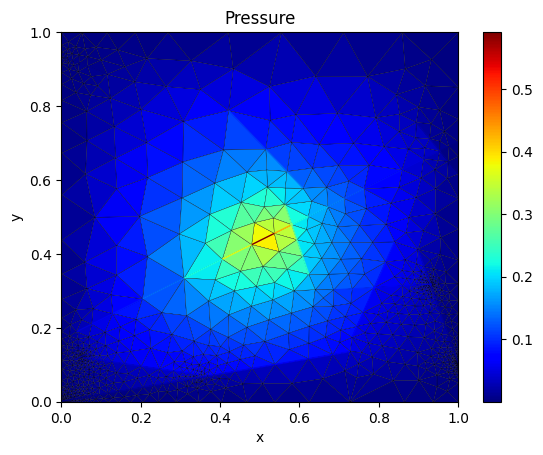

In [ ]:
pp.plot_grid(
    model.mdg,
    "pressure",
    figsize=(10, 8),
    linewidth=0.2,
    title='Pressure',
    plot_2d=True,
)

# Gmsh properties of the model 

In [26]:
model.mdg.subdomains

<bound method MixedDimensionalGrid.subdomains of Mixed-dimensional grid containing 16 grids and 19 interfaces.
Maximum dimension present: 2 
Minimum dimension present: 0 
1 grids of dimension 2 with in total 1526 cells
11 grids of dimension 1 with in total 136 cells
4 grids of dimension 0 with in total 4 cells
11 interfaces between grids of dimension 2 and 1 with in total 272 mortar cells.
8 interfaces between grids of dimension 1 and 0 with in total 16 mortar cells.
>

## Some mesh quality measures and their statistics 

In [27]:
gmsh.initialize()
gmsh.open("mesh_2d.msh")  # Replace with your actual filename

dim = 2  # Looking for 2D elements (triangles)

types, elemTags, nodeTags = gmsh.model.mesh.getElements(dim)

# Gmsh triangle element type is 2 (3-node triangle)
triangle_type = 2

if triangle_type not in types:
    print("No triangular elements found.")
    gmsh.finalize()
else:
    tri_index = np.where(types == triangle_type)[0][0]
    triangles = nodeTags[tri_index].reshape(-1, 3)

    # Get node coordinates
    node_ids, coords, _ = gmsh.model.mesh.getNodes()
    coords = coords.reshape(-1, 3)
    node_id_to_index = {nid: i for i, nid in enumerate(node_ids)}

    # Compute triangle areas
    areas = []
    n=0
    for tri in triangles:
        n=n+1
        pts = [coords[node_id_to_index[nid]] for nid in tri]
        v1 = np.array([pts[1][0], pts[1][1], 0.0]) - np.array([pts[0][0], pts[0][1], 0.0])
        v2 = np.array([pts[2][0], pts[2][1], 0.0]) - np.array([pts[0][0], pts[0][1], 0.0])
        area = 0.5 * np.linalg.norm(np.cross(v1, v2))
        areas.append(area)

    areas = np.array(areas)
    cell_sizes = np.sqrt(areas)

    # Output statistics
    print("Number of triangle elements:", len(cell_sizes))
    print(f"Min cell size:  {cell_sizes.min():.4e}")
    print(f"Max cell size:  {cell_sizes.max():.4e}")
    print(f"Mean cell size: {cell_sizes.mean():.4e}")
    print("Unique cell sizes:", np.unique(cell_sizes))
    print(f"Number of triangles: {n}")

    

Info    : Reading 'mesh_2d.msh'...
Info    : 135 entities
Info    : 817 nodes
Info    : 1801 elements
Info    : Done reading 'mesh_2d.msh'
Number of triangle elements: 1526
Min cell size:  1.2028e-04
Max cell size:  9.6023e-02
Mean cell size: 1.9003e-02
Unique cell sizes: [0.00012028 0.00012442 0.00012955 ... 0.08998026 0.09362923 0.09602338]
Number of triangles: 1526


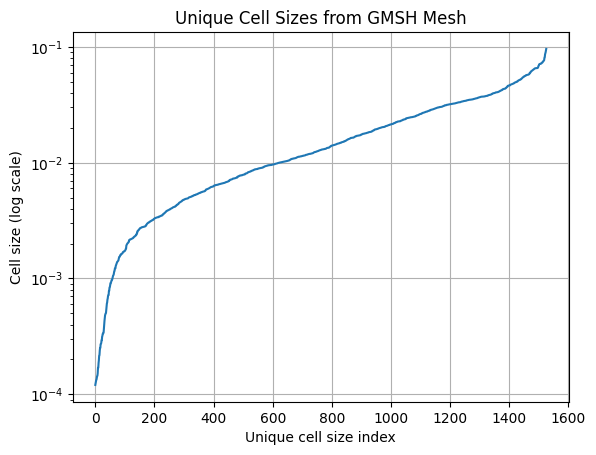

In [28]:
plt.plot( np.unique(cell_sizes))
plt.yscale("log")
plt.xlabel("Unique cell size index")
plt.ylabel("Cell size (log scale)")
plt.title("Unique Cell Sizes from GMSH Mesh")
plt.grid(True)
plt.show()

In [29]:
gmsh.model.mesh.getElementTypes()
gmsh.finalize()

In [30]:
# ----- Configuration -----
mesh_file = "mesh_2d.msh"  # Path to your Gmsh mesh file
output_csv = "mesh_quality_metrics.csv"  # Output file for results
# -------------------------

print(f"Analyzing mesh: {mesh_file}")
gmsh.initialize()
gmsh.open(mesh_file)

triangle_type = 2  # Gmsh type ID for 3-node triangle
dim = 2  # 2D elements

# Extract all triangle elements
types, _, nodeTags = gmsh.model.mesh.getElements(dim)
if triangle_type not in types:
    gmsh.finalize()
    raise ValueError("No triangle elements found.")

tri_index = np.where(types == triangle_type)[0][0]
triangles = nodeTags[tri_index].reshape(-1, 3)

# Extract node coordinates
node_ids, coords, _ = gmsh.model.mesh.getNodes()
coords = coords.reshape(-1, 3)
node_id_to_index = {nid: i for i, nid in enumerate(node_ids)}

# ---- Geometry-based helper functions ----
def triangle_area(p0, p1, p2):
    v1, v2 = p1 - p0, p2 - p0
    cross = np.cross(np.append(v1[:2], 0), np.append(v2[:2], 0))
    return 0.5 * np.linalg.norm(cross)

def aspect_ratio(p0, p1, p2):
    a, b, c = np.linalg.norm(p1 - p0), np.linalg.norm(p2 - p1), np.linalg.norm(p0 - p2)
    s = 0.5 * (a + b + c)
    area = triangle_area(p0, p1, p2)
    inr = area / s if s != 0 else 0
    cr = (a * b * c) / (4 * area) if area != 0 else np.inf
    return cr / inr if inr != 0 else np.inf

def triangle_angles(p0, p1, p2):
    def angle(a, b, c):
        ba = a - b
        bc = c - b
        cosa = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        return np.arccos(cosa) * 180 / np.pi
    
    angles = [angle(p1, p0, p2), angle(p0, p1, p2), angle(p0, p2, p1)]
    return min(angles), max(angles)

def compute_sicn(p0, p1, p2, area):
    a, b, c = np.linalg.norm(p1 - p0), np.linalg.norm(p2 - p1), np.linalg.norm(p0 - p2)
    denom = a**2 + b**2 + c**2
    return (2 * math.sqrt(3) * area / denom) if denom > 0 else 0

def compute_gamma(p0, p1, p2, area):
    a, b, c = np.linalg.norm(p1 - p0), np.linalg.norm(p2 - p1), np.linalg.norm(p0 - p2)
    denom = a**2 + b**2 + c**2
    return (4 * math.sqrt(3) * area / denom) if denom > 0 else 0

def compute_sige(p0, p1, p2):
    a, b, c = np.linalg.norm(p1 - p0), np.linalg.norm(p2 - p1), np.linalg.norm(p0 - p2)
    longest = max(a, b, c)
    def altitude(a, b, c):
        s = 0.5 * (a + b + c)
        area = math.sqrt(max(s * (s - a) * (s - b) * (s - c), 0))
        return (2 * area) / a if a != 0 else np.inf
    altitudes = [altitude(a, b, c), altitude(b, c, a), altitude(c, a, b)]
    return longest / min(altitudes) if min(altitudes) > 0 else np.inf

# ---- Compute mesh metrics ----
areas, sizes, ratios, min_angles, max_angles = [], [], [], [], []
centers, sicn_vals, gamma_vals, sige_vals = [], [], [], []

for tri in triangles:
    pts = [coords[node_id_to_index[nid]][:2] for nid in tri]
    p0, p1, p2 = map(np.array, pts)
    area = triangle_area(p0, p1, p2)
    size = math.sqrt(area)
    ar = aspect_ratio(p0, p1, p2)
    angles = triangle_angles(p0, p1, p2)
    sicn = compute_sicn(p0, p1, p2, area)
    gamma = compute_gamma(p0, p1, p2, area)
    sige = compute_sige(p0, p1, p2)
    center = np.mean([p0, p1, p2], axis=0)

    areas.append(area)
    sizes.append(size)
    ratios.append(ar)
    min_angles.append(angles[0])
    max_angles.append(angles[1])
    centers.append(center)
    sicn_vals.append(sicn)
    gamma_vals.append(gamma)
    sige_vals.append(sige)

# ---- Mesh grading: compare to nearest neighbor ----
tree = cKDTree(centers)
grading_ratios = []
for i, center in enumerate(centers):
    _, idxs = tree.query(center, k=2)
    h1, h2 = sizes[i], sizes[idxs[1]]
    grading_ratios.append(max(h1 / h2, h2 / h1))

# ---- Create DataFrame ----
df = pd.DataFrame({
    "Element Size": sizes,
    "Aspect Ratio": ratios,
    "Min Angle (deg)": min_angles,
    "Max Angle (deg)": max_angles,
    "Grading Ratio": grading_ratios,
    "SICN": sicn_vals,
    "Gamma": gamma_vals,
    "SIGE": sige_vals
})

gmsh.finalize()

# ---- Save to CSV ----
df.to_csv(output_csv, index=False)
print(f"\n✅ Results saved to '{output_csv}'")


Analyzing mesh: mesh_2d.msh
Info    : Reading 'mesh_2d.msh'...
Info    : 135 entities
Info    : 817 nodes
Info    : 1801 elements
Info    : Done reading 'mesh_2d.msh'

✅ Results saved to 'mesh_quality_metrics.csv'


The DataFram df contains element size, aspect ration, angles, etc. calculated for each triangle. See df and its statistics below

In [37]:
df

,Element Size,Aspect Ratio,Min Angle (deg),Max Angle (deg),Grading Ratio,SICN,Gamma,SIGE
0,0.022530,2.135069,45.379666,74.169090,1.069899,0.471361,0.942723,1.553731
1,0.004901,2.077691,50.151089,72.339019,1.190496,0.483858,0.967716,1.471443
2,0.007762,2.375224,39.129032,85.964904,1.392095,0.432489,0.864978,1.931880
3,0.018194,2.211524,44.876294,80.648841,1.102485,0.459929,0.919857,1.718283
4,0.014028,2.303940,40.039106,82.487590,1.369851,0.441917,0.883834,1.827829
...,...,...,...,...,...,...,...,...
1521,0.000339,4.343109,25.166732,119.146147,1.063005,0.292282,0.584565,3.520623
1522,0.000706,2.286902,41.610272,83.089938,2.080158,0.446508,0.893017,1.818359
1523,0.009541,2.828232,32.232277,97.753746,1.056763,0.378423,0.756845,2.424675
1524,0.001004,2.078864,48.136670,69.920676,1.197732,0.482566,0.965131,1.429088


In [42]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
       Element Size  Aspect Ratio  Min Angle (deg)  Max Angle (deg)  \
count   1526.000000   1526.000000      1526.000000      1526.000000   
mean       0.019003      2.210712        47.096705        75.729263   
std        0.017158      0.261617         7.112880        10.558605   
min        0.000120      2.000000        19.858754        60.000000   
25%        0.005939      2.039146        42.334151        67.220929   
50%        0.012883      2.127173        47.695852        73.451077   
75%        0.029029      2.288873        52.822990        82.526324   
max        0.096023      4.588885        60.000000       121.235088   

       Grading Ratio         SICN        Gamma         SIGE  
count    1526.000000  1526.000000  1526.000000  1526.000000  
mean        1.139668     0.463616     0.927233     1.618624  
std         0.126408     0.035010     0.070021     0.352110  
min         1.000201     0.272609     0.545218     1.154701  
25%         1.049110     0.44

Next, we plot the distibution of the calculated measures 

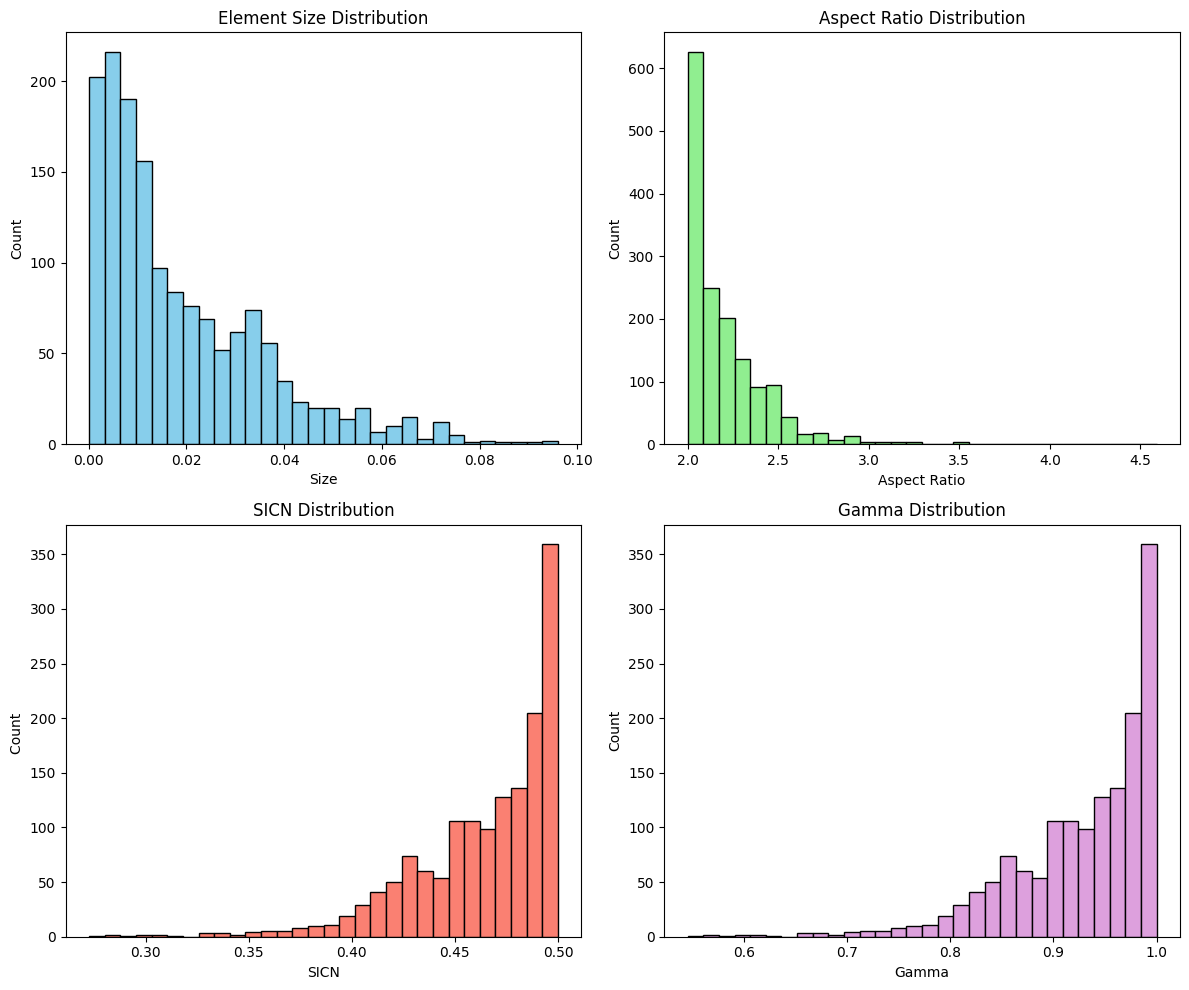

In [43]:
# ---- Plot Histograms with Logarithmic Y-axis is isLog=True----

isTrue= False
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(df["Element Size"], bins=30, color='skyblue', edgecolor='k', log=isTrue)
plt.title("Element Size Distribution")
plt.xlabel("Size")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
plt.hist(df["Aspect Ratio"], bins=30, color='lightgreen', edgecolor='k', log=isTrue)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")

plt.subplot(2, 2, 3)
plt.hist(df["SICN"], bins=30, color='salmon', edgecolor='k', log=isTrue)
plt.title("SICN Distribution")
plt.xlabel("SICN")
plt.ylabel("Count ")

plt.subplot(2, 2, 4)
plt.hist(df["Gamma"], bins=30, color='plum', edgecolor='k', log=isTrue)
plt.title("Gamma Distribution")
plt.xlabel("Gamma")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


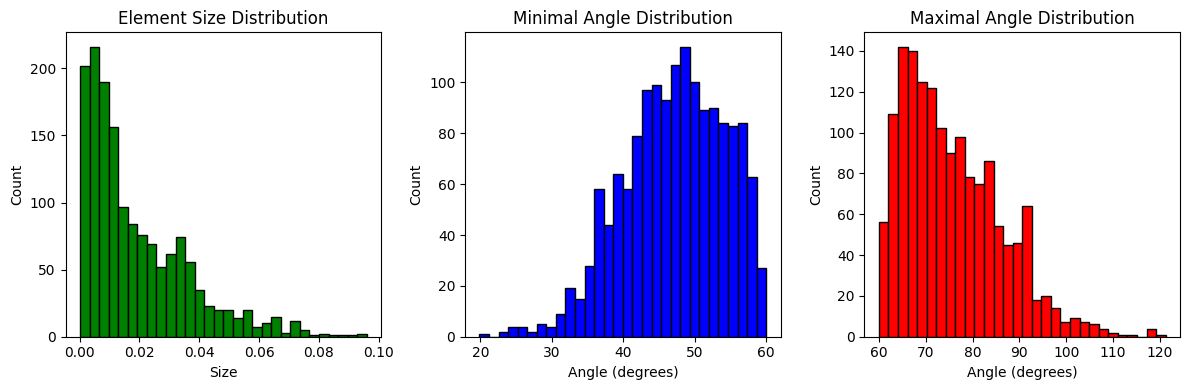

In [44]:
# ---- Plot Histograms ----

isTrue = False # Set to True for logarithmic scale, False for linear scale
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df["Element Size"], bins=30, color='green', edgecolor='k', log=isTrue)
plt.title("Element Size Distribution")
plt.xlabel("Size")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.hist(df["Min Angle (deg)"], bins=30, color='blue', edgecolor='k', log=isTrue)
plt.title("Minimal Angle Distribution")
plt.xlabel("Angle (degrees)")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
plt.hist(df["Max Angle (deg)"], bins=30, color='red', edgecolor='k', log=isTrue)
plt.title("Maximal Angle Distribution")
plt.xlabel("Angle (degrees)")
plt.ylabel("Count")


plt.tight_layout()
plt.show()

Perhaps it makes sense to bin in log scale, and take quantiles in log setting as well (?)  
See for example below!

Text(0, 0.5, 'Count')

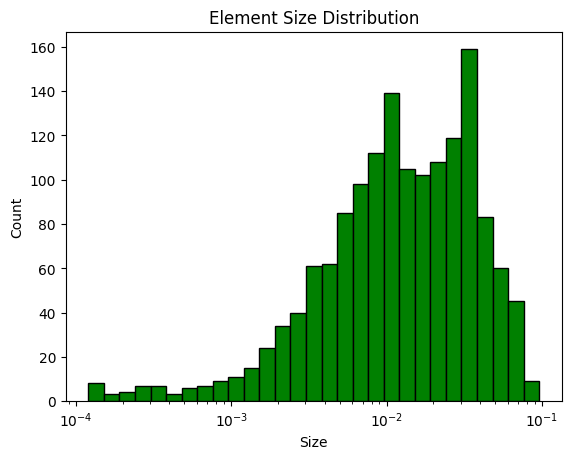

In [45]:

data = df["Element Size"]

# Define log-spaced bins between min and max
bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 30)


plt.hist(data, bins=bins, color='green', edgecolor='k')
plt.xscale("log")
plt.title("Element Size Distribution")
plt.xlabel("Size")
plt.ylabel("Count")

## Problematic elements

Let us plot some of the problematic triangles to visualize:   
1. Create triangles from the mesh  
2. Check if the min angle is smaller that a given threshold, and max angle is larger
3. Color the problematic triangles (elements)

In [39]:
# Function to extract triangle coordinates from a Gmsh mesh file
def extract_triangle_coords(mesh_file="mesh_2d.msh"):
    gmsh.initialize()
    gmsh.open(mesh_file)

    triangle_type = 2  # 3-node triangle
    dim = 2

    types, _, nodeTags = gmsh.model.mesh.getElements(dim)
    tri_index = np.where(types == triangle_type)[0][0]
    triangles = nodeTags[tri_index].reshape(-1, 3)

    node_ids, coords, _ = gmsh.model.mesh.getNodes()
    coords = coords.reshape(-1, 3)
    node_id_to_index = {nid: i for i, nid in enumerate(node_ids)}

    triangle_coords = []
    for tri in triangles:
        pts = [coords[node_id_to_index[nid]][:2] for nid in tri]
        triangle_coords.append(pts)

    gmsh.finalize()
    return triangle_coords

triangle_coords = extract_triangle_coords("mesh_2d.msh")

Info    : Reading 'mesh_2d.msh'...
Info    : 135 entities
Info    : 817 nodes
Info    : 1801 elements
Info    : Done reading 'mesh_2d.msh'


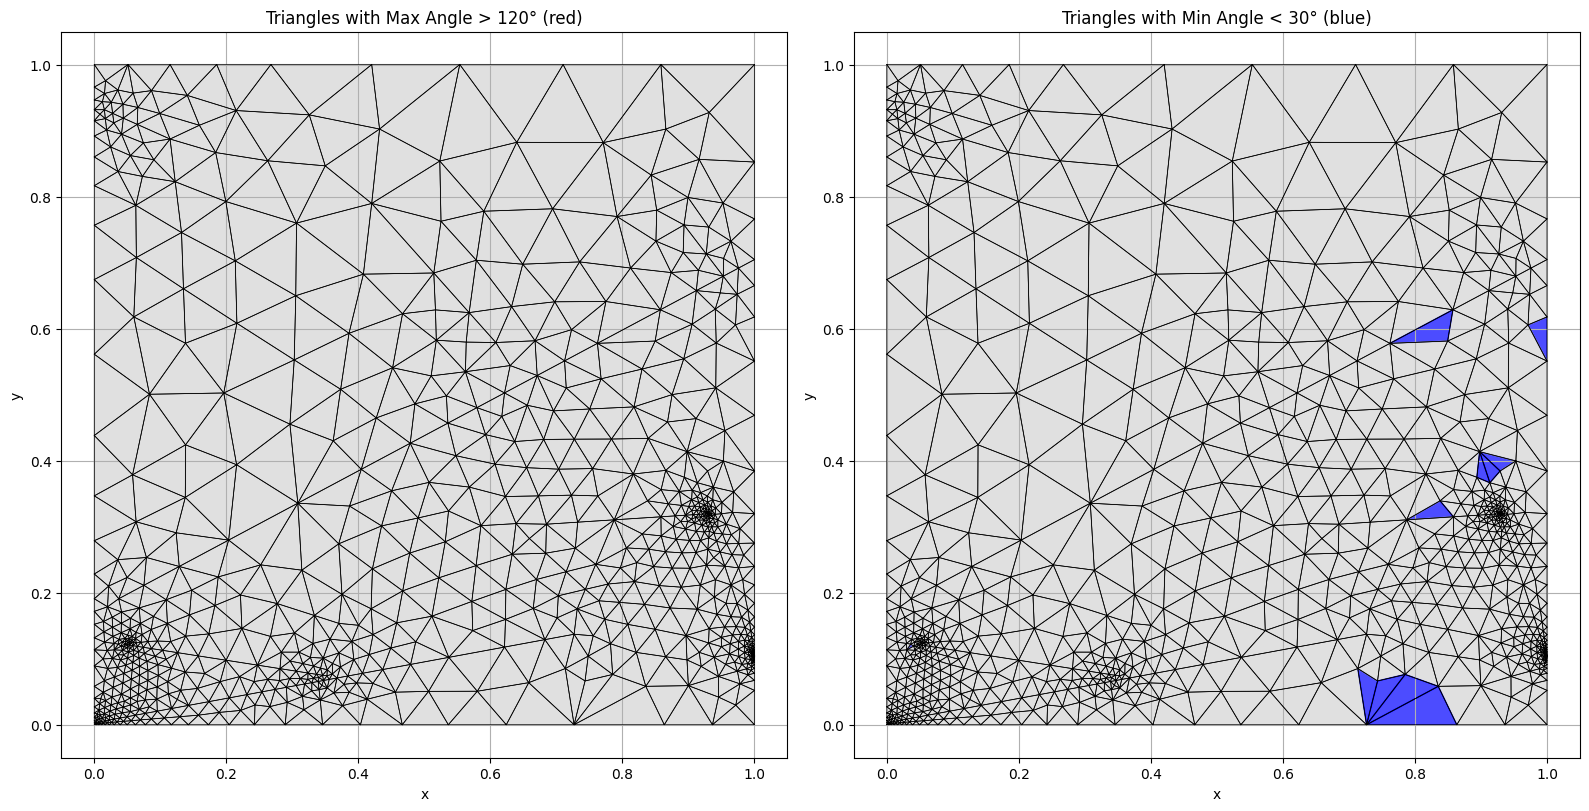

In [40]:
angle_max_threshold = 120
angle_min_threshold = 30

# Compute angle flags from DataFrame

max_angle_flags = df["Max Angle (deg)"] > angle_max_threshold
min_angle_flags = df["Min Angle (deg)"] < angle_min_threshold

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Max Angle Plot ---
ax = axes[0]
for tri, is_bad in zip(triangle_coords, max_angle_flags):
    tri_closed = np.array(tri + [tri[0]])
    color = 'red' if is_bad else 'lightgrey'
    ax.plot(tri_closed[:, 0], tri_closed[:, 1], 'k-', linewidth=0.5)
    ax.fill(tri_closed[:, 0], tri_closed[:, 1], color=color, alpha=0.7)

ax.set_title(f"Triangles with Max Angle > {angle_max_threshold}° (red)")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)

# --- Min Angle Plot ---
ax = axes[1]
for tri, is_bad in zip(triangle_coords, min_angle_flags):
    tri_closed = np.array(tri + [tri[0]])
    color = 'blue' if is_bad else 'lightgrey'
    ax.plot(tri_closed[:, 0], tri_closed[:, 1], 'k-', linewidth=0.5)
    ax.fill(tri_closed[:, 0], tri_closed[:, 1], color=color, alpha=0.7)

ax.set_title(f"Triangles with Min Angle < {angle_min_threshold}° (blue)")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)

plt.tight_layout()
plt.show()

Plot both in the same plot

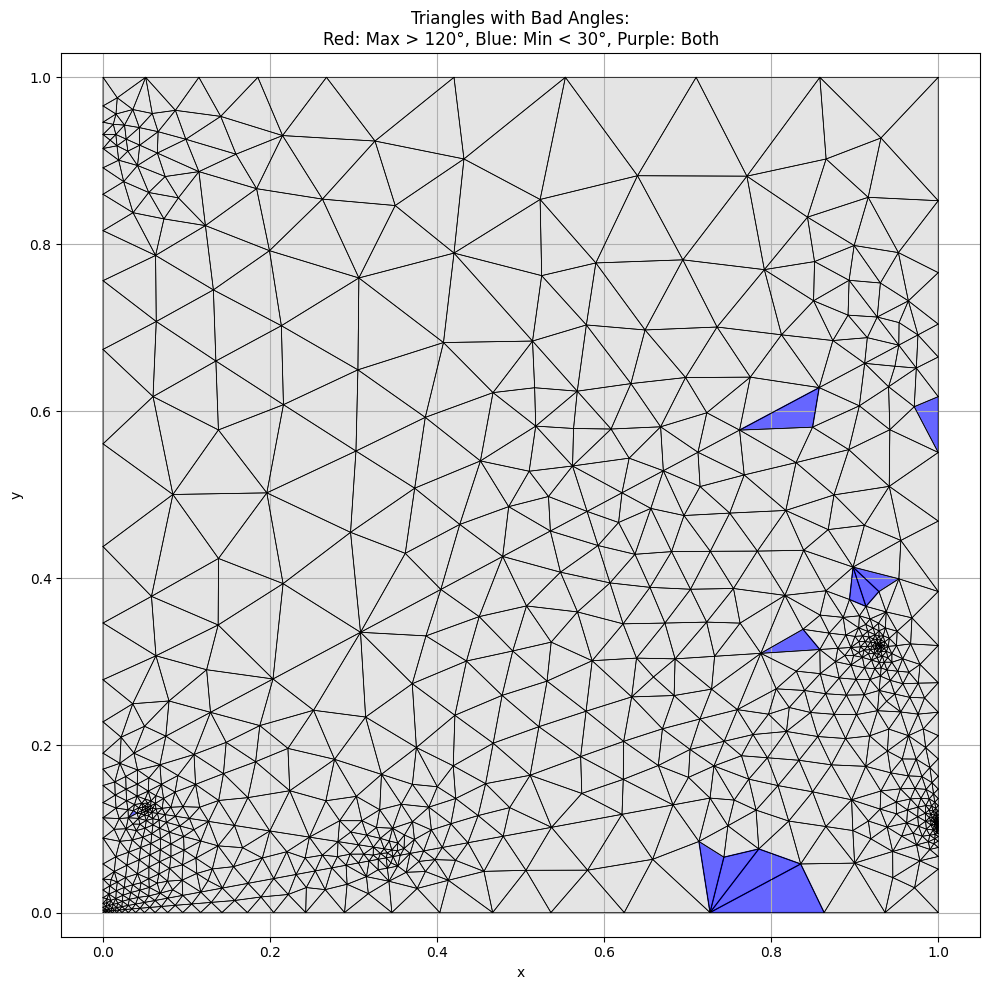

In [33]:
angle_max_threshold = 120
angle_min_threshold = 30

# Compute angle flags from DataFrame
max_angle_flags = df["Max Angle (deg)"] > angle_max_threshold
min_angle_flags = df["Min Angle (deg)"] < angle_min_threshold

# Combine both flags
both_flags = list(zip(max_angle_flags, min_angle_flags))

# Plot: one figure with red (bad max), blue (bad min), purple (both)
plt.figure(figsize=(10, 10))
for tri, (is_max_bad, is_min_bad) in zip(triangle_coords, both_flags):
    tri_closed = np.array(tri + [tri[0]])

    if is_max_bad and is_min_bad:
        color = 'purple'  # both bad
    elif is_max_bad:
        color = 'red'
    elif is_min_bad:
        color = 'blue'
    else:
        #continue 
        color = 'lightgrey'

    plt.plot(tri_closed[:, 0], tri_closed[:, 1], 'k-', linewidth=0.5)
    plt.fill(tri_closed[:, 0], tri_closed[:, 1], color=color, alpha=0.6)

plt.title(
    f"Triangles with Bad Angles:\n"
    f"Red: Max > {angle_max_threshold}°, Blue: Min < {angle_min_threshold}°, Purple: Both"
)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
print("Number of bad triangles:")
print(f"🔺 Number of triangles with max angle > {angle_max_threshold}°: {max_angle_flags.sum()}")
print(f"🔻 Number of triangles with min angle < {angle_min_threshold}°: {min_angle_flags.sum()}")

Number of bad triangles:
🔺 Number of triangles with max angle > 120°: 1
🔻 Number of triangles with min angle < 30°: 20
